<a href="https://colab.research.google.com/github/kaed7n/classification-models-comparison-diabetes/blob/main/classification_models_comparison_diabetes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Classification Models Comparison:**
## ***Diabetes Prediction***

In [1]:
# import packages:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, RocCurveDisplay, ConfusionMatrixDisplay
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

## Pima Indians diabetes dataset from Github/Kaggle

In [2]:
# load in data
PimaDiabetesURL = "https://raw.githubusercontent.com/plotly/datasets/master/diabetes.csv"
pima_diabetes_data = pd.read_csv(PimaDiabetesURL)

# quick look at data for needed cleaning/transformation
print("Shape:", pima_diabetes_data.shape)
display(pima_diabetes_data.head())
print("\nNulls:\n", pima_diabetes_data.isnull().sum())
display(pima_diabetes_data.describe())

Shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1



Nulls:
 Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


## *No nulls + zero values for certain colums -> Will treat impossible zero values as null.*

In [3]:
# ---- 2. Clean Data & Split ----
# Remove/replace impossible 0 values with null values in some columns, then fill with median
cols_w_bad_zeros = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]

# Check # of zeros in columns before:
print("Zeros before cleaning:")
print((pima_diabetes_data[cols_w_bad_zeros] == 0).sum().sort_values(ascending=False))

# Replace 0s with NaN and then impute missing values with median
for c in cols_w_bad_zeros:
    pima_diabetes_data[c] = pima_diabetes_data[c].replace(0, np.nan)
    pima_diabetes_data[c] = pima_diabetes_data[c].fillna(pima_diabetes_data[c].median())

# Define features and target
X = pima_diabetes_data.drop(columns=["Outcome"])
y = pima_diabetes_data["Outcome"]

# Train/test split -> 80:20
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=777, stratify=y
)

print("\nShapes:")
print("Train:", X_train.shape, "Test:", X_test.shape)


Zeros before cleaning:
Insulin          374
SkinThickness    227
BloodPressure     35
BMI               11
Glucose            5
dtype: int64

Shapes:
Train: (614, 8) Test: (154, 8)


## Metrics Helper

In [4]:

def print_metrics(y_true, y_pred, y_proba, name="Model"):
    # Prints standard classification metrics, ROC, AUC..
    # y_proba should be positive class probability.

    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    f1   = f1_score(y_true, y_pred, zero_division=0)
    try:
        auc  = roc_auc_score(y_true, y_proba)
    except ValueError:
        auc = float("nan")
    print(f"{name}: ACC={acc:.3f}  PREC={prec:.3f}  REC={rec:.3f}  F1={f1:.3f}  ROC-AUC={auc:.3f}")
    return name, acc, prec, rec, f1, auc

## Logistic Regression Model

Logistic Regression: ACC=0.760  PREC=0.698  REC=0.556  F1=0.619  ROC-AUC=0.813


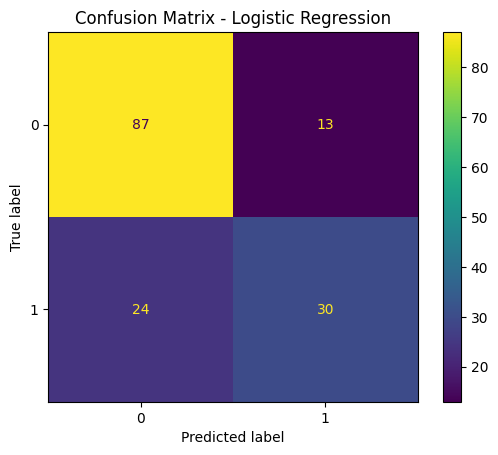

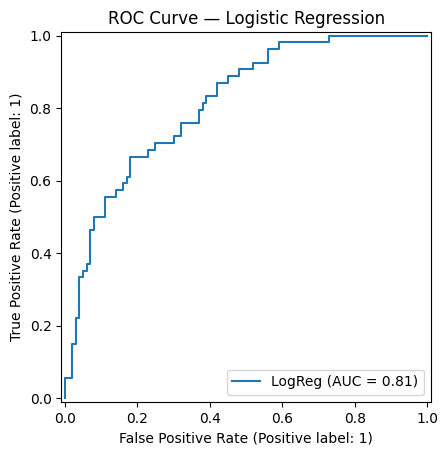

In [5]:
num_features = list(X.columns)

scaler = ColumnTransformer(
    transformers=[("num", StandardScaler(), num_features)],
    remainder="drop"
)

log_reg = Pipeline(steps=[
    ("scale", scaler),
    ("clf", LogisticRegression(max_iter=1000, random_state=777))
])

log_reg.fit(X_train, y_train)

y_pred_lr  = log_reg.predict(X_test)
y_proba_lr = log_reg.predict_proba(X_test)[:, 1]
lr_scores  = print_metrics(y_test, y_pred_lr, y_proba_lr, name="Logistic Regression")
# Model selects second column to predict hard label for true probability
# Plot Confusion matrix
fig, ax = plt.subplots()
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_lr, ax=ax)
ax.set_title("Confusion Matrix - Logistic Regression")
plt.show()

# Plot ROC curve
fig, ax = plt.subplots()
RocCurveDisplay.from_predictions(y_test, y_proba_lr, ax=ax, name="LogReg")
ax.set_title("ROC Curve — Logistic Regression")
plt.show()


## Random Forest Model

Random Forest: ACC=0.747  PREC=0.653  REC=0.593  F1=0.621  ROC-AUC=0.839


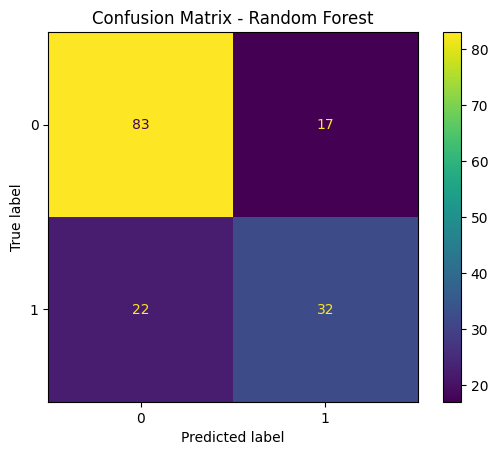

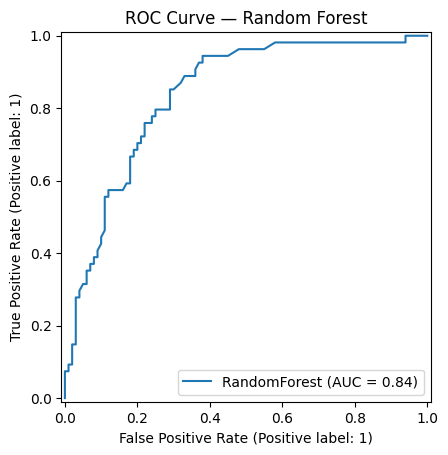

In [6]:

rf = RandomForestClassifier(
    n_estimators=300,
    random_state=777,
    class_weight="balanced_subsample"
)

rf.fit(X_train, y_train)

y_pred_rf  = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]
rf_scores  = print_metrics(y_test, y_pred_rf, y_proba_rf, name="Random Forest")

# Confusion matrix
fig, ax = plt.subplots()
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf, ax=ax)
ax.set_title("Confusion Matrix - Random Forest")
plt.show()

# ROC curve
fig, ax = plt.subplots()
RocCurveDisplay.from_predictions(y_test, y_proba_rf, ax=ax, name="RandomForest")
ax.set_title("ROC Curve — Random Forest")
plt.show()


## Gradient Boosting Model

Gradient Boosting: ACC=0.753  PREC=0.660  REC=0.611  F1=0.635  ROC-AUC=0.829


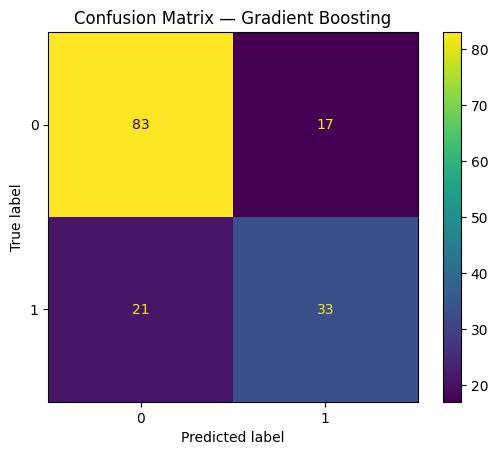

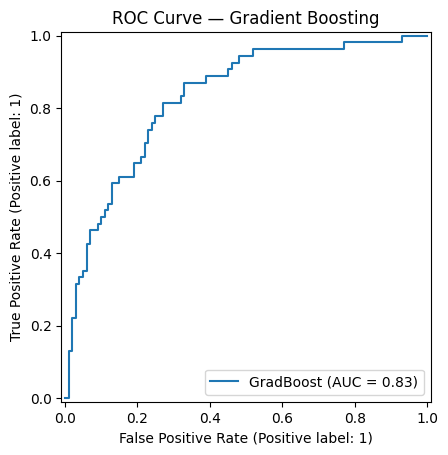

In [7]:
gb = GradientBoostingClassifier(random_state=777)
gb.fit(X_train, y_train)

y_pred_gb  = gb.predict(X_test)
y_proba_gb = gb.predict_proba(X_test)[:, 1]
gb_scores  = print_metrics(y_test, y_pred_gb, y_proba_gb, name="Gradient Boosting")

# Confusion Matrix
fig, ax = plt.subplots()
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_gb, ax=ax)
ax.set_title("Confusion Matrix — Gradient Boosting")
plt.show()

# ROC Curve
fig, ax = plt.subplots()
RocCurveDisplay.from_predictions(y_test, y_proba_gb, ax=ax, name="GradBoost")
ax.set_title("ROC Curve — Gradient Boosting")
plt.show()


## Feature Importance
Tree-based models: Random Forest + Gradient Boosting

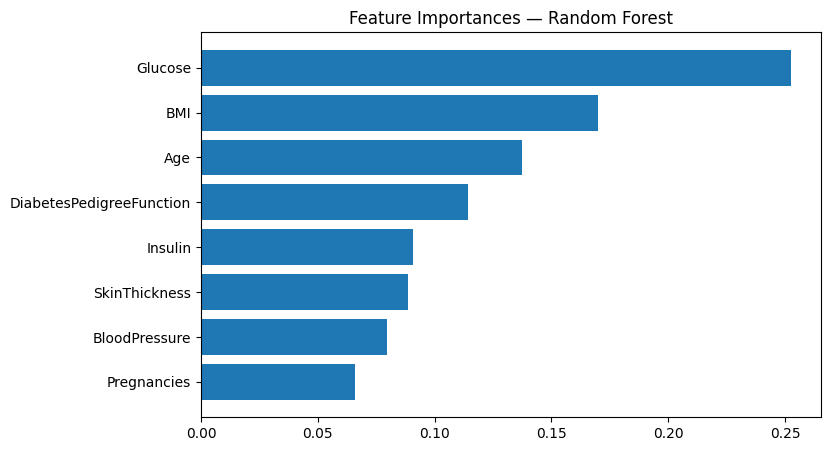

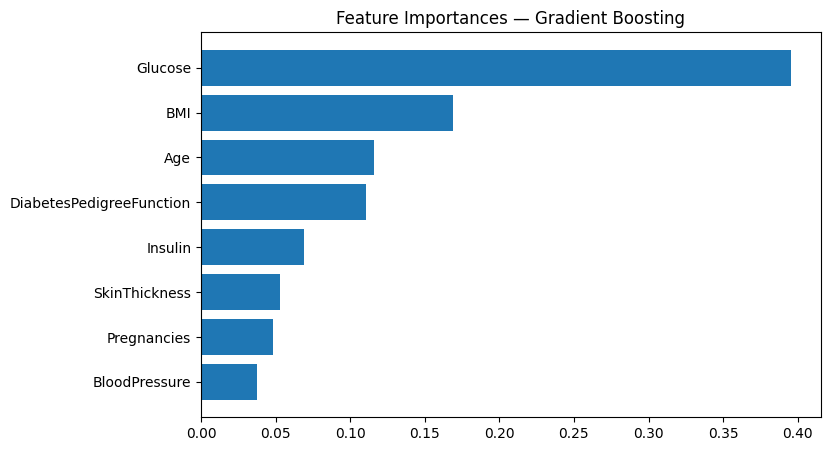

Top 5 Features — Random Forest


,Feature,Importance
1,Glucose,0.252782
5,BMI,0.170103
7,Age,0.137329
6,DiabetesPedigreeFunction,0.114497
4,Insulin,0.090678


Top 5 Features — Gradient Boosting


,Feature,Importance
1,Glucose,0.395825
5,BMI,0.169265
7,Age,0.116226
6,DiabetesPedigreeFunction,0.110447
4,Insulin,0.069295


In [8]:
# Define variables
importances_rf = rf.feature_importances_
importances_gb = gb.feature_importances_

# Create DFs for view of importances
fi_rf = pd.DataFrame({
    "Feature": X.columns,
    "Importance": importances_rf
}).sort_values(by="Importance", ascending=False)

fi_gb = pd.DataFrame({
    "Feature": X.columns,
    "Importance": importances_gb
}).sort_values(by="Importance", ascending=False)

# Plot Random Forest
fig, ax = plt.subplots(figsize=(8, 5))
ax.barh(fi_rf["Feature"], fi_rf["Importance"])
ax.set_title("Feature Importances — Random Forest")
plt.gca().invert_yaxis()
plt.show()

# Plot Gradient Boosting
fig, ax = plt.subplots(figsize=(8, 5))
ax.barh(fi_gb["Feature"], fi_gb["Importance"])
ax.set_title("Feature Importances — Gradient Boosting")
plt.gca().invert_yaxis()
plt.show()

# Show top 5 features from random forest
print("Top 5 Features — Random Forest")
display(fi_rf.head())
# Top 5 features from GB
print("Top 5 Features — Gradient Boosting")
display(fi_gb.head())


Both tree models have good AUC, but FI is pretty different to each other. Gradient Boosting model having surprising importance score of approx. 0.4 for glucose compared to just 0.25 for the RF model. Yet, both have a good AUC value with just a difference of 0.1 between.

## Model Comparison

In [9]:
# Create columns for metrics
cols = ["Accuracy","Precision","Recall","F1Score","ROC_AUC"]
rows = []

# LR row, name column added for each row, grabbing/seperating by defining variables from defined scores(metrics) variables
(lr_name, lr_acc, lr_prec, lr_rec, lr_f1, lr_auc) = lr_scores
rows.append([lr_name, lr_acc, lr_prec, lr_rec, lr_f1, lr_auc])
# RF row
(rf_name, rf_acc, rf_prec, rf_rec, rf_f1, rf_auc) = rf_scores
rows.append([rf_name, rf_acc, rf_prec, rf_rec, rf_f1, rf_auc])
# GB row
(gb_name, gb_acc, gb_prec, gb_rec, gb_f1, gb_auc) = gb_scores
rows.append([gb_name, gb_acc, gb_prec, gb_rec, gb_f1, gb_auc])

# Create DF making model name an index column
comparison_df = pd.DataFrame(rows, columns=["Model"] + cols).set_index("Model").round(3)
display(comparison_df)

# DF filtered for best AUC
best_by_auc = comparison_df["ROC_AUC"].idxmax()
print(f"Best by ROC-AUC: {best_by_auc}")

,Accuracy,Precision,Recall,F1Score,ROC_AUC
Model,,,,,
Logistic Regression,0.760,0.698,0.556,0.619,0.813
Random Forest,0.747,0.653,0.593,0.621,0.839
Gradient Boosting,0.753,0.660,0.611,0.635,0.829


Best by ROC-AUC: Random Forest


## Summary

In [10]:
# For Readme, etc.

summary_lines = [f"{idx}: " +
                 ", ".join([f"{m}={comparison_df.loc[idx, m]:.3f}" for m in cols])
                 for idx in comparison_df.index]
summary_text = "Results — Test Set\n" + "\n".join("- " + s for s in summary_lines)
print(summary_text)

Results — Test Set
- Logistic Regression: Accuracy=0.760, Precision=0.698, Recall=0.556, F1Score=0.619, ROC_AUC=0.813
- Random Forest: Accuracy=0.747, Precision=0.653, Recall=0.593, F1Score=0.621, ROC_AUC=0.839
- Gradient Boosting: Accuracy=0.753, Precision=0.660, Recall=0.611, F1Score=0.635, ROC_AUC=0.829
